<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Discrete_ver_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import FloatSlider, IntSlider
pd.options.display.max_rows = 999
#https://github.com/DataHerb/dataset-covid-19/tree/master/csse_covid_19_time_series

In [0]:
def get_actual_ts(key='confirmed',country='Italy',rolling=4):
  """
    retrive informaton from actual cases database
    Parameters: 
    key (str): "confirmed", "recovered" or "dead"
    country (str): defult is italy (not case sensetive)
    rolling (int): rolling average for the daily cases
  
    Returns: 
    pandas dataframe: based on the type of the key
  
  """
 
  if key == "confirmed":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
  elif key == "recovered":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
  elif key == "dead":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
  else:
    return -1


  df_=df[df['Country/Region'].str.lower()==country.lower()].T  
  df_ = df_.iloc[4:]
  df_ = df_.set_index(pd.to_datetime(df_.index))
  df_.columns=['cumulative']
  df_['daily'] = df_['cumulative'] - df_['cumulative'].shift(1).fillna(0)
  df_['rolling'] = df_['daily'].rolling(rolling).mean()
  return df_


![alt text](https://raw.githubusercontent.com/akhavan12/discrete_covid_model/master/Model_Discrete_v4_new.svg)


In [0]:
## Precision for the calculations
prc = 2
lenght_t = 70
Beta = .0015
T = []
initial_population = 1000000


def set_probs_Other_Exposed(Probs):
  ### Other_Exp,Other_Symp
  Probs["Other_Exposed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.30,0.70], #3
          [0.00,1.00], #4
  ]
def set_probs_Other_Symp(Probs):
  ### Other_Symp,Susceptible   
  Probs['Other_Symp'] =[[0.80,  0.20],
                        [0.50,  0.50 ], 
                        [0.00,  1.00]]      

def set_probs_M(Probs):
  ### M,R,Severe
  Probs["M"] = [
          [1.00,0.00,0.00], #0
          [0.80,0.00,0.20], #1
          [0.60,0.00,0.40], #2
          [0.50,0.10,0.40], #3
          [0.40,0.40,0.20], #4
          [0.30,0.30,0.40], #5
          [0.30,0.50,0.20], #6
          [0.30,0.50,0.20], #7
          [0.30,0.50,0.20], #8
          [0.30,0.50,0.20], #9
          [0.30,0.50,0.20], #10 
          [0.30,0.50,0.20], #11
          [0.20,0.60,0.20], #12 
          [0.00,0.00,1] #13
  ]
def set_probs_MU(Probs):
  ### MU,R
  Probs["M_undiagnosed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.50,0.50], #3
          [0.40,0.60], #4
          [0.30,0.70], #5
          [0.30,0.70], #6
          [0.30,0.70], #7
          [0.30,0.70], #8
          [0.30,0.70], #9
          [0.30,0.70], #10 
          [0.30,0.70], #11
          [0.30,0.70], #12 
          [0.00,1.00]  #13
  ]

def set_probs_Severe(Probs):
  ### Severe,R,V,D
  Probs["Severe"] = [
          [0.70,0.10,0.10,0.10], #0
          [0.70,0.10,0.10,0.10], #1
          [0.70,0.10,0.10,0.10], #2
          [0.40,0.10,0.30,0.20], #3
          [0.30,0.30,0.30,0.20], #4
          [0.10,0.40,0.30,0.20], #5
          [0.10,0.40,0.30,0.20], #6
          [0.10,0.40,0.30,0.20], #7
          [0.10,0.40,0.30,0.20], #8
          [0.10,0.40,0.30,0.20], #9
          [0.10,0.40,0.30,0.20], #10
          [0.10,0.40,0.30,0.20], #11
          [0.10,0.40,0.30,0.20], #12
          [0.00,0.00,1.00,0.00]  #13
        ]

def set_probs_ventilator(Probs):
  ### V,R,D 
  Probs["ventilator"] = [
          [0.50,0.45,0.05], #0
          [0.40,0.55,0.05], #1
          [0.40,0.55,0.05], #2
          [0.30,0.65,0.05], #3
          [0.40,0.20,0.30], #6
          [0.40,0.20,0.30], #7
          [0.40,0.20,0.30], #8
          [0.10,0.10,0.80], #9
          [0.10,0.10,0.80], #10
          [0.10,0.10,0.80], #11
          [0.10,0.10,0.80], #12
          [0.00,0.00,1.00]  #13
          ] 

def set_probs_Symp(Probs):
  ### Symp,M   0: not tested, 1: tested positive ,2: tested negative
  Probs['Symp'] =[[0.20,  0.80 , 0.00 ], #0 Testing and + cases go to Mild cases , negative cases go back to Healthy
                  [0.00,  0.60 , 0.40 ]]      #1 ###  all remainings go to Mild cases 

def set_probs_E(Probs):
  ### E,Symp
  Probs["E"] = [[1.00,0.00], #0 ### first day of exposure
                [0.50,0.50], #1       
                [0.40,0.60], #2 
                [0.30,0.70], #4
                [0.20,0.80], #5
                [0.10,0.90], #6
                [0.05,0.95], #7
                [0.05,0.95], #8
                [0.05,0.95], #9
                [0.05,0.95], #10
                [0.05,0.95], #11
                [0.05,0.95], #12
                [0.05,0.95], #13
                [0.05,0.95], #14
                [0.05,0.95], #15
                [0.05,0.95], #16
                [0.05,0.95], #17
                [0.05,0.95], #18
                [0.05,0.95], #19
                [0.00,1.00]  #20
                ]


P={}
EXP_Other =[]
MU = []     ## Mild undiagnosed
E = []       ## Exposed 
H = []      ## Healthy (susceptible)
Symp = []   ## Symptomatic
M = []      ## Mild Symptomatic
W = []      ## Severe
V = []       ## Ventilator
R = []      ## Recovered
D = []      ## Dead
add_M = []  
add_sym = [] 
add_E = [] 
add_Severe = []
add_ventilator = []


def calculate():
  global P
  global EXP_Other

  global MU     ## Mild undiagnosed
  global E      ## Exposed 
  global H      ## Healthy (susceptible)
  global Symp   ## Symptomatic
  global M      ## Mild Symptomatic
  global W      ## Severe
  global V      ## Ventilator
  global R      ## Recovered
  global D      ## Dead
  global add_M  
  global add_sym 
  global add_E 
  global add_Severe
  global add_ventilator



  P={}
  set_probs_Severe(P)
  set_probs_ventilator(P)
  set_probs_Symp(P)
  set_probs_E(P)
  set_probs_M(P)
  #### Other deiseases variables: NOT COVID
  set_probs_Other_Exposed(P)
  set_probs_Other_Symp
  EXP_Other = np.zeros((len(P['Other_Exposed']),lenght_t))
  #### COVID variables
  set_probs_MU(P) ### undiagnosed MILD COVID
  MU = np.zeros((len(P['M_undiagnosed']),lenght_t))
  E = np.zeros((len(P['E']),lenght_t))
  Symp = np.zeros((len(P['Symp']),lenght_t))
  M = np.zeros((len(P['M']),lenght_t))
  W = np.zeros((len(P['Severe']),lenght_t))
  V = np.zeros((len(P['ventilator']),lenght_t))
  R = np.zeros(lenght_t)
  D = np.zeros(lenght_t)
  H = np.zeros(lenght_t)

  add_M = []
  add_sym = []
  add_E = []
  add_Severe = []
  add_ventilator = []
############################################################
############################################################
############################################################
  print(E.shape)
  E[0,0] = 10
  M[0,0] = 0
############################################################
############################################################
############################################################
  H[0] = initial_population - E[0,0]



  for t in range(lenght_t-1):
    R[t+1] = R[t]
    D[t+1] = D[t]

    for state in range(len(P['E'])):
      try:
        E[state+1,t+1] =  np.round(E[state,t] * P["E"][state][0],prc) ## Stay exposed conditions
      except:
        pass
      Symp[0,t+1] = np.round(Symp[0,t+1] + E[state,t] * P["E"][state][1],prc)  ## at time t+1 add the portion of the Exposed to the symptomatic
    ### Symptomatic states Tests take place here
    #################################################                            0      1 
    Symp[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][0],prc)         ### P["Symp"][0][0] ==> [[0,1]  [0,1]]
                                                      ###                      |   |   |  |   
                                                      ###         next day    Symp M
                                                      ###         next day             Symp M
    ### from Symptomatic to mild --> where testing also happens
    M[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][1],prc)                 ### From state 0 to Mild state 0
    M[1,t+1] = np.round(M[1,t+1] +  Symp[1,t] * P["Symp"][1][1],prc)     ### From state 1 to Mild state 0

    MU[0,t+1] = np.round(Symp[0,t] * P["Symp"][0][2],prc)                 ### From state 0 to Mild state 0
    MU[0,t+1] = np.round(MU[0,t+1] +  Symp[1,t] * P["Symp"][1][2],prc)     ### From state 1 to Mild state 0


    #################################################
    #add_sym.append(Symp[0,t] - (Symp[0,t] * P["Symp"][0][0]+Symp[0,t] * P["Symp"][0][1]))
    #add_sym.append(Symp[1,t] -  Symp[1,t] * P["Symp"][1][1] )

    ### Mild cases are calculated in this section
    for state in range(1,len(P['M'])):
      ### M,R,Severe
      try:
        M[state+1,t+1] =  np.round(M[state,t] * P["M"][state][0],prc) ## from state= state --> to state+1
      except:
        pass
      R[t+1] = np.round(R[t+1] + M[state,t] * P["M"][state][1],prc) ## from Mild to recovered
      W[0,t+1] = W[0,t+1] + np.round(M[state,t] * P["M"][state][2],prc)


    ###############################################
    ### Un-diagnosed Mild 
    for state in range(0,len(P['M_undiagnosed'])):
      ### M,R,Severe
      try:
        MU[state+1,t+1] =  np.round(MU[state,t] * P["M_undiagnosed"][state][0],prc) ## from state= state --> to state+1
      except:
        pass

      R[t+1] = np.round(R[t+1] + MU[state,t] * P["M_undiagnosed"][state][1],prc) ## from undiagnosed_Mild to recovered
      #if MU[state,t] * P["M_undiagnosed"][state][1]>0:
        #print(state, t,':', MU[state,t] * P["M_undiagnosed"][state][1])

    ##########################################
    ### Severe Cases 

    for state in range(0,len(P['Severe'])):
    ### Severe,R,V,D
      try:
        W[state+1,t+1] =  np.round(W[state,t] * P["Severe"][state][0],prc)
      except:
        pass
      R[t+1] = np.round(R[t+1] + W[state,t] * P["Severe"][state][1],prc)

      if W[state,t] * P["Severe"][state][2]>0:
        V[0,t+1] = V[0,t+1] + np.round(W[state,t] * P["Severe"][state][2],prc)

      D[t+1] = D[t+1] + np.round(W[state,t] * P["Severe"][state][3],prc)


    ###########################################
    ### ventilator cases

    for state in range(0,len(P['ventilator'])):
    ### V,R,D 
      try: 
        V[state+1,t+1] = np.round( V[state,t] * P["ventilator"][state][0],prc)
      except:
        pass
      R[t+1] = R[t+1] + np.round(V[state,t] * P["ventilator"][state][1],prc)
      D[t+1] = D[t+1] + np.round(V[state,t] * P["ventilator"][state][2],prc)



    if H[t] >(H[t] *  M[:,t].sum() * Beta):
      E[0,t+1] = (H[t] *  M[:,t].sum() * Beta)
      H[t+1]= H[t] - np.round(E[0,t+1])
    elif ((H[t]>0) & (H[t]<(H[t] *  M[:,t].sum() * Beta))):
      E[0,t+1] = H[t]

      H[t+1]= 0

In [0]:
#E_    = pd.DataFrame(E.T).astype('int16')
#M_    = pd.DataFrame(M.T).astype('int16')
#W_    = pd.DataFrame(W.T).astype('int16')
#V_    = pd.DataFrame(V.T).astype('int16')
#H_    = pd.DataFrame(H,columns=['H']).astype('int16')
#Symp_ = pd.DataFrame(Symp.T,columns=['Symp_0','Symp_1']).astype('int16')

"""E_    = pd.DataFrame(E.T,columns=['E_0','E_1','E_2','E_3','E_4']).astype('int16')
Symp_ = pd.DataFrame(Symp.T,columns=['Symp_0','Symp_1']).astype('int16')
M_    = pd.DataFrame(M.T,columns=['M_0','M_1','M_2','M_3','M_4','M_5','M_6','M_7','M_8','M_9','M_10','M_11','M_12','M_13']).astype('int16')
W_    = pd.DataFrame(W.T,columns=['W_0','W_1','W_2','W_3','W_4','W_5','W_6','W_7','W_8','W_9','W_10','W_11','W_12','W_13']).astype('int16')
#V_    = pd.DataFrame(V.T,columns=['V_0','V_1','V_2','V_3','V_4','V_5','V_6','V_7','V_8','V_9','V_10','V_11','V_12','V_13'])
H_    = pd.DataFrame(H,columns=['H']).astype('int16')
R_    = pd.DataFrame(R,columns=['R']).astype('int16')
D_    = pd.DataFrame(D,columns=['D']).astype('int16')
"""

"E_    = pd.DataFrame(E.T,columns=['E_0','E_1','E_2','E_3','E_4']).astype('int16')\nSymp_ = pd.DataFrame(Symp.T,columns=['Symp_0','Symp_1']).astype('int16')\nM_    = pd.DataFrame(M.T,columns=['M_0','M_1','M_2','M_3','M_4','M_5','M_6','M_7','M_8','M_9','M_10','M_11','M_12','M_13']).astype('int16')\nW_    = pd.DataFrame(W.T,columns=['W_0','W_1','W_2','W_3','W_4','W_5','W_6','W_7','W_8','W_9','W_10','W_11','W_12','W_13']).astype('int16')\n#V_    = pd.DataFrame(V.T,columns=['V_0','V_1','V_2','V_3','V_4','V_5','V_6','V_7','V_8','V_9','V_10','V_11','V_12','V_13'])\nH_    = pd.DataFrame(H,columns=['H']).astype('int16')\nR_    = pd.DataFrame(R,columns=['R']).astype('int16')\nD_    = pd.DataFrame(D,columns=['D']).astype('int16')\n"

In [0]:
calculate()

(20, 70)


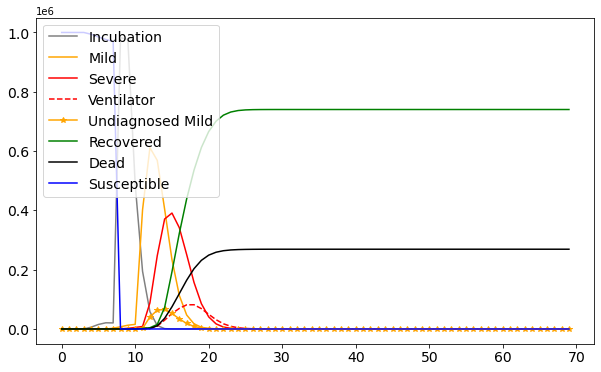

In [0]:
f,ax = plt.subplots(figsize=(10,6))
ax.plot(E.sum(axis=0),color='gray',label = 'Incubation')
ax.plot(M.sum(axis=0),color='orange', label ='Mild')
ax.plot(W.sum(axis=0),color='red', label ='Severe')
ax.plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

ax.plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


ax.plot(R,color='green', label = 'Recovered')
ax.plot(D,color='Black', label = 'Dead')
#ax.plot(R+D,'.-',color='yellow', label = 'NOT')
ax.plot(H,color='blue', label = 'Susceptible')
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)


In [0]:
def Interactive_deriv(B,L):
  global lenght_t 
  global Beta
  Beta = B
  lenght_t = L
  calculate()
  f,ax = plt.subplots(figsize=(10,6))
  ax.plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax.plot(M.sum(axis=0),color='orange', label ='Mild')
  ax.plot(W.sum(axis=0),color='red', label ='Severe')
  ax.plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax.plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')

  
  ax.plot(R,color='green', label = 'Recovered')
  ax.plot(D,color='Black', label = 'Dead')
  #ax.plot(R+D,'.-',color='yellow', label = 'NOT')
  ax.plot(H,color='blue', label = 'Susceptible')
  
  
  
  
  #### Catual data
  act_dead = get_ts(key='dead', country='Italy',rolling=7)
  
  
  
  ax.plot(act_dead['cumulative'].values,'--',color='red')
  
  
  ax.tick_params(labelsize=14)
  ax.legend(fontsize=14)



#readout_format='.6f',

w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.1, max=1,     continuous_update=False,   step=.001, value=.1, description = 'Beta'),
    L = IntSlider(min=10, max=100,     continuous_update=False,   step=1, value=40, description = 'length of simmulation') )



In [0]:
w

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Beta', max=1.0, min=0.1, st…

## Comparison

In [0]:
## Precision for the calculations
prc = 2
lenght_t = 70
Beta = .0015
T = []
initial_population = 1000

P={}
EXP_Other =[]
MU = []     ## Mild undiagnosed
E = []       ## Exposed 
H = []      ## Healthy (susceptible)
Symp = []   ## Symptomatic
M = []      ## Mild Symptomatic
W = []      ## Severe
V = []       ## Ventilator
R = []      ## Recovered
D = []      ## Dead
add_M = []  
add_sym = [] 
add_E = [] 
add_Severe = []
add_ventilator = []


def calculate_extra():
  global P
  global EXP_Other

  global MU     ## Mild undiagnosed
  global E      ## Exposed 
  global H      ## Healthy (susceptible)
  global Symp   ## Symptomatic
  global M      ## Mild Symptomatic
  global W      ## Severe
  global V      ## Ventilator
  global R      ## Recovered
  global D      ## Dead
  global add_M  
  global add_sym 
  global add_E 
  global add_Severe
  global add_ventilator



  P={}
  set_probs_Severe(P)
  set_probs_ventilator(P)
  set_probs_Symp(P)
  set_probs_E(P)
  set_probs_M(P)
  #### Other deiseases variables: NOT COVID
  set_probs_Other_Exposed(P)
  set_probs_Other_Symp
  EXP_Other = np.zeros((len(P['Other_Exposed']),lenght_t))
  #### COVID variables
  set_probs_MU(P) ### undiagnosed MILD COVID
  MU = np.zeros((len(P['M_undiagnosed']),lenght_t))
  E = np.zeros((len(P['E']),lenght_t))
  Symp = np.zeros((len(P['Symp']),lenght_t))
  M = np.zeros((len(P['M']),lenght_t))
  W = np.zeros((len(P['Severe']),lenght_t))
  V = np.zeros((len(P['ventilator']),lenght_t))
  R = np.zeros(lenght_t)
  D = np.zeros(lenght_t)
  H = np.zeros(lenght_t)

  add_M = []
  add_sym = []
  add_E = []
  add_Severe = []
  add_ventilator = []
############################################################
############################################################
############################################################
  print(E.shape)
  E[0,0] = 10
  M[0,0] = 0
############################################################
############################################################
############################################################
  H[0] = initial_population - E[0,0]



  for t in range(lenght_t-1):
    R[t+1] = R[t]
    D[t+1] = D[t]

    for state in range(len(P['E'])):
      try:
        E[state+1,t+1] =  np.round(E[state,t] * P["E"][state][0],prc) ## Stay exposed conditions
      except:
        pass
      Symp[0,t+1] = np.round(Symp[0,t+1] + E[state,t] * P["E"][state][1],prc)  ## at time t+1 add the portion of the Exposed to the symptomatic
    ### Symptomatic states Tests take place here
    #################################################                            0      1 
    Symp[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][0],prc)         ### P["Symp"][0][0] ==> [[0,1]  [0,1]]
                                                      ###                      |   |   |  |   
                                                      ###         next day    Symp M
                                                      ###         next day             Symp M
    ### from Symptomatic to mild --> where testing also happens
    M[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][1],prc)                 ### From state 0 to Mild state 0
    M[1,t+1] = np.round(M[1,t+1] +  Symp[1,t] * P["Symp"][1][1],prc)     ### From state 1 to Mild state 0

    MU[0,t+1] = np.round(Symp[0,t] * P["Symp"][0][2],prc)                 ### From state 0 to Mild state 0
    MU[0,t+1] = np.round(MU[0,t+1] +  Symp[1,t] * P["Symp"][1][2],prc)     ### From state 1 to Mild state 0


    #################################################
    #add_sym.append(Symp[0,t] - (Symp[0,t] * P["Symp"][0][0]+Symp[0,t] * P["Symp"][0][1]))
    #add_sym.append(Symp[1,t] -  Symp[1,t] * P["Symp"][1][1] )

    ### Mild cases are calculated in this section
    for state in range(1,len(P['M'])):
      ### M,R,Severe
      try:
        M[state+1,t+1] =  np.round(M[state,t] * P["M"][state][0],prc) ## from state= state --> to state+1
      except:
        pass
      R[t+1] = np.round(R[t+1] + M[state,t] * P["M"][state][1],prc) ## from Mild to recovered
      W[0,t+1] = W[0,t+1] + np.round(M[state,t] * P["M"][state][2],prc)


    ###############################################
    ### Un-diagnosed Mild 
    for state in range(0,len(P['M_undiagnosed'])):
      ### M,R,Severe
      try:
        MU[state+1,t+1] =  np.round(MU[state,t] * P["M_undiagnosed"][state][0],prc) ## from state= state --> to state+1
      except:
        pass

      R[t+1] = np.round(R[t+1] + MU[state,t] * P["M_undiagnosed"][state][1],prc) ## from undiagnosed_Mild to recovered
      #if MU[state,t] * P["M_undiagnosed"][state][1]>0:
        #print(state, t,':', MU[state,t] * P["M_undiagnosed"][state][1])

    ##########################################
    ### Severe Cases 

    for state in range(0,len(P['Severe'])):
    ### Severe,R,V,D
      try:
        W[state+1,t+1] =  np.round(W[state,t] * P["Severe"][state][0],prc)
      except:
        pass
      R[t+1] = np.round(R[t+1] + W[state,t] * P["Severe"][state][1],prc)

      if W[state,t] * P["Severe"][state][2]>0:
        V[0,t+1] = V[0,t+1] + np.round(W[state,t] * P["Severe"][state][2],prc)

      D[t+1] = D[t+1] + np.round(W[state,t] * P["Severe"][state][3],prc)


    ###########################################
    ### ventilator cases

    for state in range(0,len(P['ventilator'])):
    ### V,R,D 
      try: 
        V[state+1,t+1] = np.round( V[state,t] * P["ventilator"][state][0],prc)
      except:
        pass
      R[t+1] = R[t+1] + np.round(V[state,t] * P["ventilator"][state][1],prc)
      D[t+1] = D[t+1] + np.round(V[state,t] * P["ventilator"][state][2],prc)



    if H[t] >(H[t] *  M[:,t].sum() * Beta):
      E[0,t+1] = (H[t] *  M[:,t].sum() * Beta)
      H[t+1]= H[t] - np.round(E[0,t+1])
    elif ((H[t]>0) & (H[t]<(H[t] *  M[:,t].sum() * Beta))):
      E[0,t+1] = H[t]

      H[t+1]= 0

# Italy

In [0]:
def Interactive_deriv(B,L,Delay,normalization_factor):
  global lenght_t 
  global Beta
  Beta = B
  lenght_t = L
  calculate_extra()
  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed")
  df_actual_dead = get_actual_ts(key="dead")
  df_actual_recovered = get_actual_ts(key="recovered")

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')
  #ax[0].plot(H,color='blue', label = 'Susceptible')



  ax[1].plot(df_actual_confirm['rolling'].values[Delay:]/normalization_factor,label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[Delay:]/normalization_factor,label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[Delay:]/normalization_factor, label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title('Italy')
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.000001, max=0.003,     continuous_update=False, readout_format='.8f',   step=.0000001, value=.0005, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=100, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=25, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=500, description = 'normalization_factor')
    
    )
w


interactive(children=(FloatSlider(value=0.0005, continuous_update=False, description='Beta', max=0.003, min=1e…

# Germany

In [0]:
Country = 'Germany'
def Interactive_deriv(B,L,Delay,normalization_factor):
  global lenght_t 
  global Beta
  global Country
  Beta = B
  lenght_t = L
  calculate_extra()
  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed",country=Country)
  df_actual_dead = get_actual_ts(key="dead",country=Country)
  df_actual_recovered = get_actual_ts(key="recovered",country=Country)

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')
  #ax[0].plot(H,color='blue', label = 'Susceptible')



  ax[1].plot(df_actual_confirm['rolling'].values[20:]/normalization_factor,label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[20:]/normalization_factor,label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[20:]/normalization_factor, label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title(Country)
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.000001, max=0.003,     continuous_update=False, readout_format='.8f',   step=.0000001, value=.00053, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=100, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=25, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=500, description = 'normalization_factor')
    
    )


## Germany SIM

In [0]:
w

interactive(children=(FloatSlider(value=0.00053, continuous_update=False, description='Beta', max=0.003, min=1…

In [0]:
Country = 'spain'
def Interactive_deriv(B,L,Delay,normalization_factor):
  global lenght_t 
  global Beta
  global Country
  Beta = B
  lenght_t = L
  calculate_extra()
  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed",country=Country)
  df_actual_dead = get_actual_ts(key="dead",country=Country)
  df_actual_recovered = get_actual_ts(key="recovered",country=Country)

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')



  ax[1].plot(df_actual_confirm['rolling'].values[20:]/normalization_factor,label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[20:]/normalization_factor,label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[20:]/normalization_factor, label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title(Country)
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.000001, max=0.003,     continuous_update=False, readout_format='.8f',   step=.0000001, value=.00053, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=100, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=25, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=500, description = 'normalization_factor')
    
    )
w

interactive(children=(FloatSlider(value=0.00053, continuous_update=False, description='Beta', max=0.003, min=1…

In [0]:
Country = 'sweden'
def Interactive_deriv(B,L,Delay,normalization_factor):
  global lenght_t 
  global Beta
  global Country
  Beta = B
  lenght_t = L
  calculate_extra()
  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed",country=Country)
  df_actual_dead = get_actual_ts(key="dead",country=Country)
  df_actual_recovered = get_actual_ts(key="recovered",country=Country)

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')



  ax[1].plot(df_actual_confirm['rolling'].values[20:]/normalization_factor,label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[20:]/normalization_factor,label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[20:]/normalization_factor, label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title(Country)
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.000001, max=0.003,     continuous_update=False, readout_format='.8f',   step=.0000001, value=.00053, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=100, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=25, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=14, description = 'normalization_factor'))
w

interactive(children=(FloatSlider(value=0.00053, continuous_update=False, description='Beta', max=0.003, min=1…

In [0]:
Country = 'spain'
def Interactive_deriv(B,L,Delay,normalization_factor):
  global lenght_t 
  global Beta
  global Country
  Beta = B
  lenght_t = L
  calculate_extra()
  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed",country=Country)
  df_actual_dead = get_actual_ts(key="dead",country=Country)
  df_actual_recovered = get_actual_ts(key="recovered",country=Country)

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')



  ax[1].plot(df_actual_confirm['rolling'].values[20:]/normalization_factor,label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[20:]/normalization_factor,label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[20:]/normalization_factor, label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title(Country)
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    B=        FloatSlider(min=0.000001, max=0.003,     continuous_update=False, readout_format='.8f',   step=.0000001, value=.00053, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=100, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=25, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=450, description = 'normalization_factor'))
w

interactive(children=(FloatSlider(value=0.00053, continuous_update=False, description='Beta', max=0.003, min=1…